# **Escenario 3: One armed bandit based model**


## Descripción del Escenario

Para este escenario vamos a simular 20 servidores de manera sencilla dentro de nuestro data center. Lo que buscamos averiguar aquí es la cantidad óptima de servidores a utilizar o si por el contrario es mejor explotar más servidores, dentro de los 20 que tenemos.

Para este escenario y teniendo en cuenta como se formulan problemas de one armed bandit, vamos a utilizar 3 métodos distintos para encontrar la mejor política posible sobre qué servidor utilizar y en qué momento cambiar. Estos son los métodos:

1. Coeficiente de Gittens (caso base)
2. Upper Confidence Bound (UCB)
3. Muestreo de Thompson

El objetivo final de esta simulación es  con base a las métricas, determinar la mejor política con tal de garantizar un funcionamiento óptimo de nuestro data center. De este modo averiguaremos cual es la mejor cantidad de servidores a explotar en un lapso de pasos.

## Diseño experimental del Escenario 3

**Problema:** Multi-armed bandit con 20 brazos (cada brazo = un servidor con rendimiento desconocido).

**Modelo de recompensas:** Bernoulli (éxito = 1, fallo = 0). Cada servidor i tiene una probabilidad fija desconocida $p_i$.

**Verdaderas probabilidades:** 20 valores homogéneos (intercambiados aleatoriamente por ejecución).

**Horizonte de evaluación:** $T = 1000$ pasos por experimento.

**Repeticiones (para promediar):** 300 corridas independientes.

**Algoritmos comparados:** UCB y Thompson Sampling (Beta-Bernoulli, priors α=β=1) e Indice de gittins

**Objetivo:** comparar desempeño en arrepentimiento acumulado, recompensa acumulada y porcentaje de selección del brazo óptimo.

## Detalles sobre la implementación

Simulación 300 ejecuciones.

##Para UCB:

- Se inicializa jugando cada brazo una vez (si T ≥ n_arms).
- Cada paso T usa $\hat{𝜇_{i}} + \sqrt{\frac{2 ln t}{n_i}}$ y elige el brazo con mayor UCB.

##Para Thompson:

- Prior $\beta(1,1)$ por brazo
- n cada paso se muestrea $θ_i ~ \beta(α_i,β_i)$ y se elige $argmax (θ_i)$
- Actualizamos $\frac{\alpha}{\beta}$ con el resultado Bernoulli.

##Para Índice de Gittens:

- Se utiliza un modelo **Beta–Bernoulli** con prior inicial:
  $
  \beta(1,1)
  $
  para cada brazo.

- Usamos un $\gamma = 0.95$ arbitrario, dandole un valor similar a las recompensas futuras e inmediatas.

- En cada paso se calcula un **Índice de Gittins aproximado** para cada brazo usando sus parámetros $(\alpha_i, \beta_i)$.  
  El índice se define como:
  $G_i = \max \left(\frac{\alpha_i}{\alpha_i+\beta_i},\frac{\alpha_i}{\alpha_i+\beta_i} + \gamma \cdot \mathbb{E}[\theta_{i,\text{fut}}]\right)$
  donde $(\gamma = 0.95)$ es el **factor de descuento**.

- La expectativa del valor futuro se aproxima mediante:
  $ \mathbb{E}[\theta_{i,\text{fut}}] = 0.5 \left(\frac{\alpha_i + 1}{\alpha_+\beta_i+1}\right) + 0.5 \left(\frac{\alpha_i}{\alpha_i+\beta_i+1}\right)$

- Para reducir el costo computacional, los valores del índice para cada par  
  $(\alpha_i,\beta_i)$ se **guardan en caché**, evitando recomputaciones innecesarias.


## Métricas calculadas por paso y luego promediadas sobre ejecuciones (runs):

- Regret Instantáneo $\Delta_{t} = \mu^{*} - r_{t}$
- Regret Acumulado (promedio)
- Reward Acumulado (promedio)
- Porcentaje de veces que se escoje el brazo óptimo (Promedio Acumulado / paso T)

# Librerias Necesarias

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import beta

# Modelamiento de los servidores

Usamos programación orientada a objetos para diseñar nuestros servidores como máquinas de un brazo. Con un método sencillo que es _pull_ para que se pongan a trabajar. Usamos el modelo bernoulli en el cual la recompensa es binaria, ya que solo nos importa si el servidor funciona o no al recibir una solicitud.

In [74]:
class BernoulliBandit:
    def __init__(self, probs):
        self.probs = probs
        self.n_arms = len(probs)

    def pull(self, arm):
        return 1 if np.random.rand() < self.probs[arm] else 0

# Coeficiente de Gittens


In [75]:
def gittins_index(alpha, beta, discount=0.95):
    """
    Aproximación del indice de gittens para beta(alpha, beta)
    """
    expected_value = alpha / (alpha + beta)

    r1 = (alpha + 1) / (alpha + beta + 1)
    r0 = alpha / (alpha + beta + 1)

    future_val = 0.5 * r1 + 0.5 * r0

    return max(expected_value, expected_value + discount * future_val)


class Gittins:
    def __init__(self, n_arms, discount=0.95):
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)
        self.discount = discount
        self.cache = {}
        self.n_arms = n_arms

    def get_index(self, a, b):
        key = (a, b)
        if key not in self.cache:
            self.cache[key] = gittins_index(a, b, self.discount)
        return self.cache[key]

    def select_arm(self):
        indices = [self.get_index(self.alpha[i], self.beta[i])
                   for i in range(self.n_arms)]
        return np.argmax(indices)

    def update(self, arm, reward):

        key = (self.alpha[arm], self.beta[arm])

        if key in self.cache:
            del self.cache[key]

        if reward == 1:
            self.alpha[arm] += 1
        else:
            self.beta[arm] += 1

# Upper Confidence Bound

In [76]:
class UCB1:
    def __init__(self, n_arms):
        self.n = np.zeros(n_arms) + 1e-9
        self.mean = np.zeros(n_arms)
        self.t = 1
        self.n_arms = n_arms

    def select_arm(self):
        ucb_values = self.mean + np.sqrt(2 * np.log(self.t) / self.n)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.n[arm] += 1
        self.mean[arm] += (reward - self.mean[arm]) / self.n[arm]
        self.t += 1

# Muestreo de Thompson

In [77]:
class ThompsonSampling:
    def __init__(self, n_arms):
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)
        self.n_arms = n_arms

    def select_arm(self):
        return np.argmax(np.random.beta(self.alpha, self.beta))

    def update(self, arm, reward):
        if reward == 1:
            self.alpha[arm] += 1
        else:
            self.beta[arm] += 1

# Ejecución

In [78]:
def run_simulation(probs, T=1000, n_runs=300):
    n_arms = len(probs)

    ucb_rewards = np.zeros((n_runs, T))
    ts_rewards = np.zeros((n_runs, T))
    git_rewards = np.zeros((n_runs, T))

    ucb_optimal = np.zeros((n_runs, T))
    ts_optimal = np.zeros((n_runs, T))
    git_optimal = np.zeros((n_runs, T))

    best_arm = np.argmax(probs)

    for run in range(n_runs):
        env = BernoulliBandit(probs)

        ucb = UCB1(n_arms)
        ts = ThompsonSampling(n_arms)
        git = Gittins(n_arms, discount=0.95)

        for t in range(T):
            # ----------------- UCB -----------------
            arm = ucb.select_arm()
            r = env.pull(arm)
            ucb.update(arm, r)
            ucb_rewards[run, t] = r
            ucb_optimal[run, t] = 1 if arm == best_arm else 0

            # ---------------- Thompson ----------------
            arm = ts.select_arm()
            r = env.pull(arm)
            ts.update(arm, r)
            ts_rewards[run, t] = r
            ts_optimal[run, t] = 1 if arm == best_arm else 0

            # ---------------- GITTINS -----------------
            arm = git.select_arm()
            r = env.pull(arm)
            git.update(arm, r)
            git_rewards[run, t] = r
            git_optimal[run, t] = 1 if arm == best_arm else 0

    return ucb_rewards, ts_rewards, git_rewards, ucb_optimal, ts_optimal, git_optimal


np.random.seed(42)

true_means = np.array([
    0.15, 0.20, 0.22, 0.25, 0.27,
    0.30, 0.32, 0.35, 0.38, 0.40,
    0.45, 0.48, 0.50, 0.52, 0.55,
    0.58, 0.60, 0.65, 0.70, 0.75
])

np.random.shuffle(true_means)

In [79]:
T = 1000
n_runs = 300

ucb_r, ts_r, git_r, ucb_opt, ts_opt, git_opt = run_simulation(
    true_means, T=T, n_runs=n_runs
)

best_mean = np.max(true_means)

avg_ucb_regret = (best_mean - ucb_r.mean(axis=0)).cumsum()
avg_ts_regret = (best_mean - ts_r.mean(axis=0)).cumsum()
avg_git_regret = (best_mean - git_r.mean(axis=0)).cumsum()

avg_ucb_reward = ucb_r.mean(axis=0).cumsum()
avg_ts_reward = ts_r.mean(axis=0).cumsum()
avg_git_reward = git_r.mean(axis=0).cumsum()

avg_ucb_opt = ucb_opt.mean(axis=0)
avg_ts_opt = ts_opt.mean(axis=0)
avg_git_opt = git_opt.mean(axis=0)

In [80]:
final_table = pd.DataFrame({
    "Algoritmo": ["UCB", "Muestreo de Thompson", "Indice de Gittens"],
    "Recompensa acumulativa final": [avg_ucb_reward[-1], avg_ts_reward[-1], avg_git_reward[-1]],
    "Arrepentimiento acumulativo final": [avg_ucb_regret[-1], avg_ts_regret[-1], avg_git_regret[-1]],
    "Porcentaje de Brazo Optimo (t=T)": [avg_ucb_opt[-1] * 100, avg_ts_opt[-1] * 100, avg_git_opt[-1] * 100]
})

In [81]:
final_table

,Algoritmo,Recompensa acumulativa final,Arrepentimiento acumulativo final,Porcentaje de Brazo Optimo (t=T)
0,UCB,539.993333,210.006667,22.666667
1,Muestreo de Thompson,652.703333,97.296667,76.000000
2,Indice de Gittens,647.793333,102.206667,8.333333


# Gráficos


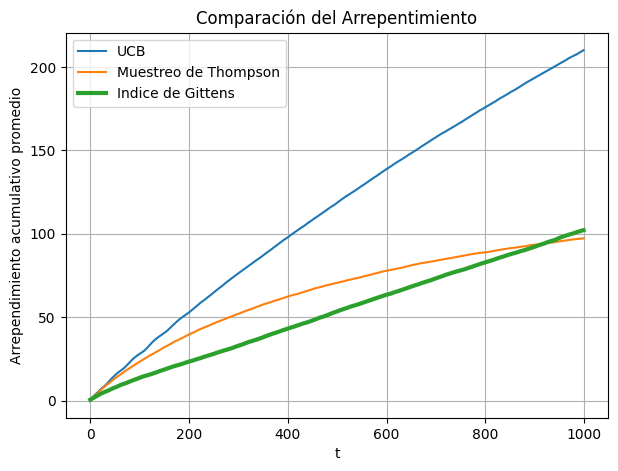

In [82]:
plt.figure(figsize=(7,5))
plt.plot(avg_ucb_regret, label="UCB")
plt.plot(avg_ts_regret, label="Muestreo de Thompson")
plt.plot(avg_git_regret, label="Indice de Gittens", linewidth=3)
plt.xlabel("t")
plt.ylabel("Arrependimiento acumulativo promedio")
plt.title("Comparación del Arrepentimiento")
plt.legend()
plt.grid()
plt.show()

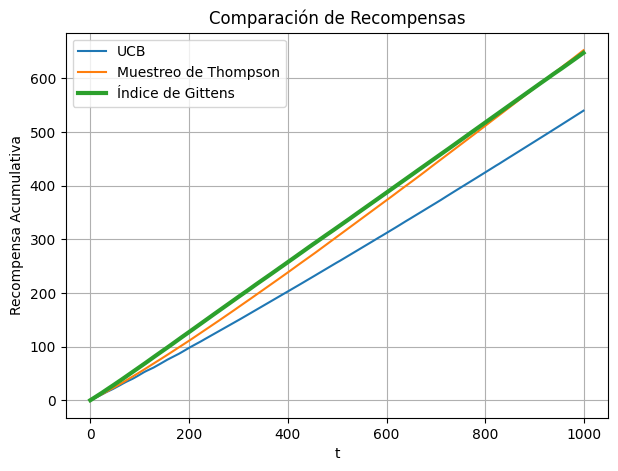

In [83]:
plt.figure(figsize=(7,5))
plt.plot(avg_ucb_reward, label="UCB")
plt.plot(avg_ts_reward, label="Muestreo de Thompson")
plt.plot(avg_git_reward, label="Índice de Gittens", linewidth=3)
plt.xlabel("t")
plt.ylabel("Recompensa Acumulativa")
plt.title("Comparación de Recompensas")
plt.legend()
plt.grid()
plt.show()

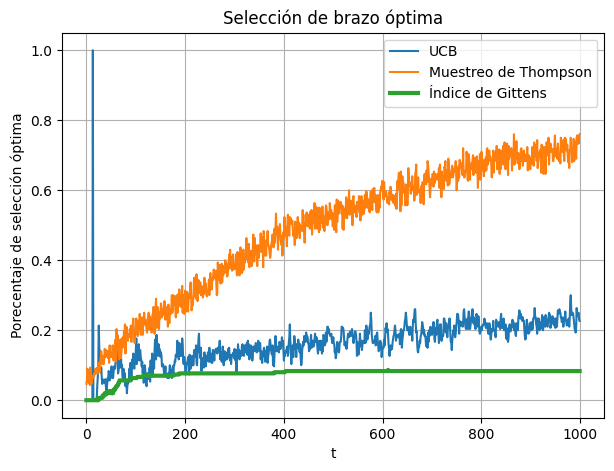

In [84]:
plt.figure(figsize=(7,5))
plt.plot(avg_ucb_opt, label="UCB")
plt.plot(avg_ts_opt, label="Muestreo de Thompson")
plt.plot(avg_git_opt, label="Índice de Gittens", linewidth=3)
plt.xlabel("t")
plt.ylabel("Porecentaje de selección óptima")
plt.title("Selección de brazo óptima")
plt.legend()
plt.grid()
plt.show()

# Análisis de resultados

El muestreo de thompson demuestra ser la métrica ganadora, y por tanto la estrategia adecuada en la cual basar nuestra política. Los motivos principales son los siguientes:

- Mayor recompensa y arrepentimiento menor: Las gráficas son concluyentes, se acumula mayor recomensa y en consecuencia el arrepentimiento disminuye. Lo que quiere decir que fué más efectivo a la hora de escoger y explotar el mejor servidor.

- Mejor identificación del brazo óptimo: Hacia el final de la simulación podemos ver como, mediante muestreo de thompson, se escogía el mejor servidor un 76% de las veces.  Demostrando un mejor balance entre explotación vs exploración.

La superioridad del muestreo de thompson dentro de nuestro experimento se debe a que incorpora naturalmente la incertidumbre mediante muestreo. Explora el brazo que tiene una chance creíble de ser óptimo lo que conduce a una convergencia rápida y eficiente.


Por otro lado tenemos al índice de Gittens. Este nos muestra un buen balance entre arrepentimiento y recompensa, baste cercano al de nuestra mejor metrica (obtenida del muestreo de thompson). Pese a su buen desempeño, muestra que solo escoge el brazo adecuado un 8.33% de las veces. Lo cual lo descarta como una buena opción

También cabe destacar que el coeficiente de gittens resulta ser una mala estrategia debido a que no sabemos exactamente que valor para el parámetro $\gamma$. Este nos indica si valoramos más las recompensas en el corto o en el largo plazo. Debido a la naturaleza incierta de los problemas de la videa real, resulta bastante impreciso.

Finalmente vemos como el UCB nos da el peor rendimiento, pues expone la menor recompensa y el arrepentimiento mayor. Mayoritariamente debido a que solo encontró el mejor brazo el 23% de las veces. La razón principal se debe a que el UCB es un algoritmo conocido por ser un poco más conservador en su exploración. En un problema con 20 brazos (servidores), toma mucho más converger a una solución óptima a comparación de la aproximación con incertidumbre incorporada por el muestreo de thompson.
